# Pre-processing + ROC AUC curve + lgbm model

This notebook applies basic pre-processing to the application_train data and applies a logistic regression, and light gbm model to the pre-processed data. An ROC AUC is used for evaluation with 5 folds (graph is plotted).

After this, the dataframes for the train and test data (with the pre-processing apllied) is saved.
This is followed by an example of reloading the files and applying a lgbm model.

In [1]:
# imports
from utils import * # contains auxillary and pre-processing methods
from models import * # contains methods for log_reg and lbgm with k-fold validation

In [2]:
#read in data - only using application_train
app_train = load_app_training_data()
app_test = load_test_data()

# get train labels and test ids
train_Y = get_train_labels(app_train)
test_ids = app_test[['SK_ID_CURR']]

Training data shape:  (307511, 122)
Testing data shape:  (48744, 121)


Defined a function to do the basic pre-processing.

This includes:
- removing days employed anomly
- label encoding
- one-hot encoding,
- removing columns with over 68% missing values
- mean imputation
- normalisation

The returned dataframes will have the **TARGET** and **SK_ID_CURR** columns dropped.


In [3]:
# do basic pre-processing
def pre_process(train_data, test_data):
    
    train_data, test_data = remove_days_employed_anomaly(train_data, test_data)
        
    'Left out neg_days_to_years and box_cox transformation as it seemed to do more harm than help'
#     train_data, test_data = neg_days_to_years(train_data, test_data)
#     train_data, lambda_map = box_cox_transform(train_data)
#     test_data, _ = box_cox_transform(test_data)
#     print("Box cox lambda", pd.Series(lambda_map, name='lambda'))
    
    train_data, test_data = encode_binary_cols(train_data, test_data)
    train_data, test_data = one_hot_encode(train_data, test_data)
    train_data, test_data = align_data(train_data, test_data)
    train_data, test_data = remove_missing_cols(train_data, test_data, thr=0.68)
    
    train_data, test_data = align_data(train_data, test_data)
    
    # need to drop TARGET and SK_ID_CURR before normalisation 
    train_data.drop(columns=['TARGET', 'SK_ID_CURR'],inplace=True)
    test_data.drop(columns=['SK_ID_CURR'], inplace= True)
    train_data, test_data = mean_imputation(train_data, test_data) # may be a bit slow
    train_data, test_data = normalise(train_data, test_data)

    return train_data, test_data

train_data, test_data = pre_process(app_train.copy(), app_test.copy())

Test data contain 9274 anomalies out of 48744 rows
Label encoded columns ['NAME_CONTRACT_TYPE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']
AFTER ONE HOT ENCODING
Training Features shape:  (307511, 244)
Testing Features shape:  (48744, 240)
AFTER ALIGNMENT:
Training Features shape:  (307511, 241)
Testing Features shape:  (48744, 240)
Removing columns with 0.68 proportion of missing values
AFTER REMOVING MISSING COLS (and aligning):
Training Features shape:  (307511, 232)
Testing Features shape:  (48744, 240)
AFTER ALIGNMENT:
Training Features shape:  (307511, 232)
Testing Features shape:  (48744, 231)
AFTER MEAN IMPUTATION:
Training data shape:  (307511, 230)
Testing data shape:  (48744, 230)
AFTER NORMALISATION:
Training data shape:  (307511, 230)
Testing data shape:  (48744, 230)


In [4]:
# convert from dataframes to arrays
train_X = train_data.values
test_X = test_data.values

Create logistic regression classifier for baseline model, and score using ROC AUC

Run 0 AUC socre: 0.6842443783052881
Run 1 AUC socre: 0.6755872318533179
Run 2 AUC socre: 0.6765742032670778
Run 3 AUC socre: 0.6815089534625713
Run 4 AUC socre: 0.6794752577699521
Avg ROC AUC score: 0.6794780049316416


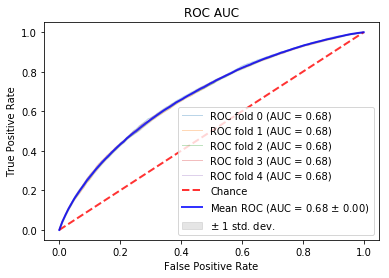

In [5]:
model, predictions = baseline_log_reg(train_X, train_Y, test_X, save_path=None, C=0.0001) # don't save model as save_path=None
cross_val_roc_curve(train_X, train_Y, model)
# create_and_save_submission(test_ids, predictions, "../test_predictions/filename.csv") # Add filename

Create a logistic regression classifier tuned using random search.

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  6.3min finished


Best C: 0.00045749926937954655
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  3.4min finished


Run 0 AUC socre: 0.7422382764462134
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  3.3min finished


Run 1 AUC socre: 0.7247755139577339
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  3.1min finished


Run 2 AUC socre: 0.7191486344236673
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  3.2min finished


Run 3 AUC socre: 0.7203949196634253
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  3.3min finished


Run 4 AUC socre: 0.743651067492434
Avg ROC AUC score: 0.7300416823966948


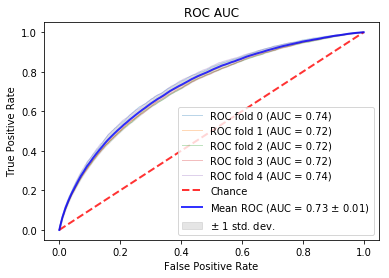

In [6]:
model, predictions = random_search_log_reg(train_X, train_Y, test_X, save_path=None)
cross_val_roc_curve(train_X, train_Y, model)

Created a light gradient boosting machine (lgbm) classifier for baseline model, and score using ROC AUC.

Run 0 AUC socre: 0.7525610754997744
Run 1 AUC socre: 0.7560237508821723
Run 2 AUC socre: 0.749355975226839
Run 3 AUC socre: 0.7547577688922125
Run 4 AUC socre: 0.7622018686761841
Avg ROC AUC score: 0.7549800878354366


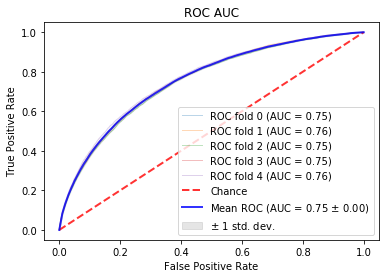

In [19]:
# NOTE : if this is very slow change n_estimators to 10 (will be much faster with scores of about 0.72)
model = lgb.LGBMClassifier(n_estimators=100, objective='binary',
                                   class_weight='balanced', learning_rate=0.05,
                                   reg_alpha=0.1, reg_lambda=0.1,
                                   subsample=0.8, n_jobs=-1, random_state=50)
cross_val_roc_curve(train_X, train_Y, model)

Created a lgbm, and trained using k-fold validation.

This model takes very long if cross_val_roc_curve(...) is used as the n_estimators is 1000.

In [7]:
feature_names = train_data.columns # required to create feature importances
model, predictions, feature_importances, metrics = gbm_basic(train_X, train_Y, test_X, feature_names, model_save_path=None, n_folds=5) # don't save model as save_path=None
# create_and_save_submission(test_ids, predictions, "../test_predictions/filename.csv") # Add filename

Training Data Shape:  (307511, 230)
Testing Data Shape:  (48744, 230)
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.754049	valid's binary_logloss: 0.564164	train's auc: 0.797368	train's binary_logloss: 0.553932
Early stopping, best iteration is:
[263]	valid's auc: 0.754659	valid's binary_logloss: 0.558257	train's auc: 0.807064	train's binary_logloss: 0.545412
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.758623	valid's binary_logloss: 0.564575	train's auc: 0.796278	train's binary_logloss: 0.555039
[400]	valid's auc: 0.758833	valid's binary_logloss: 0.546961	train's auc: 0.825526	train's binary_logloss: 0.529246
Early stopping, best iteration is:
[321]	valid's auc: 0.759134	valid's binary_logloss: 0.553367	train's auc: 0.814851	train's binary_logloss: 0.53873
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.762461	valid's binary_logloss: 0.565061	train's auc: 0.795576	train's b

The dataframes are saved to the dataframe folder to be used later.

In [8]:
# re-add the target and sk_id_currs before saving 
train_data['TARGET'] = app_train['TARGET']
train_data['SK_ID_CURR'] = app_train['SK_ID_CURR']
test_data['SK_ID_CURR'] = app_test['SK_ID_CURR']

# save dataframes 
save_pickle("../dataframes/app_train_preprocessed.pickle", train_data)
save_pickle("../dataframes/app_test_preprocessed.pickle", test_data)

File saved at  ../dataframes/app_train_preprocessed.pickle
File saved at  ../dataframes/app_test_preprocessed.pickle


An example of loading previously saved dataframes and running a lgbm on it.

Run 0 AUC socre: 0.7266660247256993
Run 1 AUC socre: 0.7252381186229924
Run 2 AUC socre: 0.7325831005410087
Run 3 AUC socre: 0.7246767897417872
Run 4 AUC socre: 0.7233297621618304
Avg ROC AUC score: 0.7264987591586636


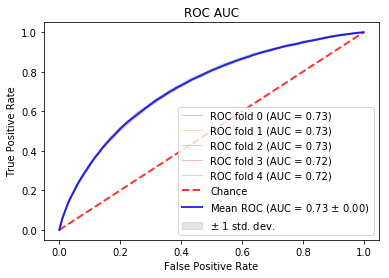

In [9]:
loaded_train = load_pickle("../dataframes/app_train_preprocessed.pickle")
loaded_test = load_pickle("../dataframes/app_test_preprocessed.pickle")

train_Y = loaded_train['TARGET'].values
loaded_train.drop(columns=['TARGET', 'SK_ID_CURR'], inplace=True)
loaded_test.drop(columns=['SK_ID_CURR'], inplace=True)

# convert from dataframes to arrays
train_X = loaded_train.values
test_X = loaded_test.values

# NOTE : if this is very slow change n_estimators to 10 (will be much faster with scores of about 0.72)
model = lgb.LGBMClassifier(n_estimators=10, objective='binary',
                                   class_weight='balanced', learning_rate=0.05,
                                   reg_alpha=0.1, reg_lambda=0.1,
                                   subsample=0.8, n_jobs=-1, random_state=50)
cross_val_roc_curve(train_X, train_Y, model)